In [39]:
import sys, os, imp
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.constants import c
from IPython.display import display, Math

In [40]:
# lumapiFile = "/opt/lumerical/v221/api/python/lumapi.py"
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
lumapi = imp.load_source("lumapi", lumapiFile)
interApi = lumapi.INTERCONNECT(hide = False)

Exception ignored in: <function Lumerical.__del__ at 0x0000029C039BA840>
Traceback (most recent call last):
  File "C:\Program Files\Lumerical\v221\api\python\lumapi.py", line 1196, in __del__
    close(self.handle)
  File "C:\Program Files\Lumerical\v221\api\python\lumapi.py", line 245, in close
    iapi.appClose(handle)
ctypes.ArgumentError: argument 1: TypeError: expected Session instance instead of Session


# Parameters

In [41]:
# units
um = 1e-6
nm = 1e-9

L = 50*um
delta_L = np.array([552.82, 55.28, 27.64])*um

wavelength = 1550*um

cband = True
# C Band simulation: 1520 - 1575 nm
# L Band simulation: 1555 - 1635 nm
if cband:
    wvlngth_start = 1.520 * um
    wvlngth_stop = 1.575 * um
else:
    wvlngth_start = 1.555 * um
    wvlngth_stop = 1.635 * um

wvg_width = 450 * nm
wvg_height = 220 * nm


# Add Devices

In [42]:
interApi.switchtolayout()
interApi.select('ONA')
interApi.delete()

# ONA

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.set('number of input ports', 2)
interApi.set('input parameter', 2)
interApi.set('start frequency', c/wvlngth_start)
interApi.set('stop frequency', c/wvlngth_stop)

# Simulation

## $FSR(\lambda)=1nm$

In [43]:
interApi.switchtolayout()
interApi.select('coupler_1')
interApi.delete()
interApi.select('coupler_2')
interApi.delete()
interApi.select('wg_1')
interApi.delete()
interApi.select('wg_2')
interApi.delete()

# Waveguide

interApi.addelement('Optical N port S-Parameter')
interApi.set('name', 'coupler_1')
interApi.set('load from file', 1)
interApi.set('s parameters filename', r"C:\Users\alves\Documents\Photonics\Mach–Zehnder interferometer\Real simulation\TE_coupler_Sparameters.dat")

interApi.copy()
interApi.set('name', 'coupler_2')

interApi.addelement('MODE Waveguide')
interApi.set('name', 'wg_1')
interApi.set('ldf filename', r"C:\Users\alves\Documents\Photonics\Mach–Zehnder interferometer\Real simulation\wvg_mode.ldf")
interApi.set('length', L)

interApi.copy()
interApi.set('name', 'wg_2')
interApi.set('length', L + delta_L[0])

In [44]:
#positions
interApi.setposition('ONA', 0, -400)
interApi.setposition('wg_1', 0,-100)
interApi.setposition('wg_2', 0, 400)
interApi.setposition('coupler_1', -250, 50)
interApi.setposition('coupler_2', 600, 50)

In [45]:
# connection

interApi.connect("ONA", "output", "coupler_1", "port upper 1")
interApi.connect("coupler_1", "port upper 2", "wg_1", "port 1")
interApi.connect("coupler_1", "port lower 2", "wg_2", "port 1")
interApi.connect("wg_1", "port 2", "coupler_2", "port upper 1")
interApi.connect("wg_2", "port 2", "coupler_2", "port lower 1")
interApi.connect("coupler_2", "port upper 2", "ONA", "input 1")
interApi.connect("coupler_2", "port lower 2", "ONA", "input 2")

1.0

In [46]:
interApi.run()

C:\Users\alves\AppData\Local\Temp\ipykernel_15396\2330698305.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(1545, -38, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)


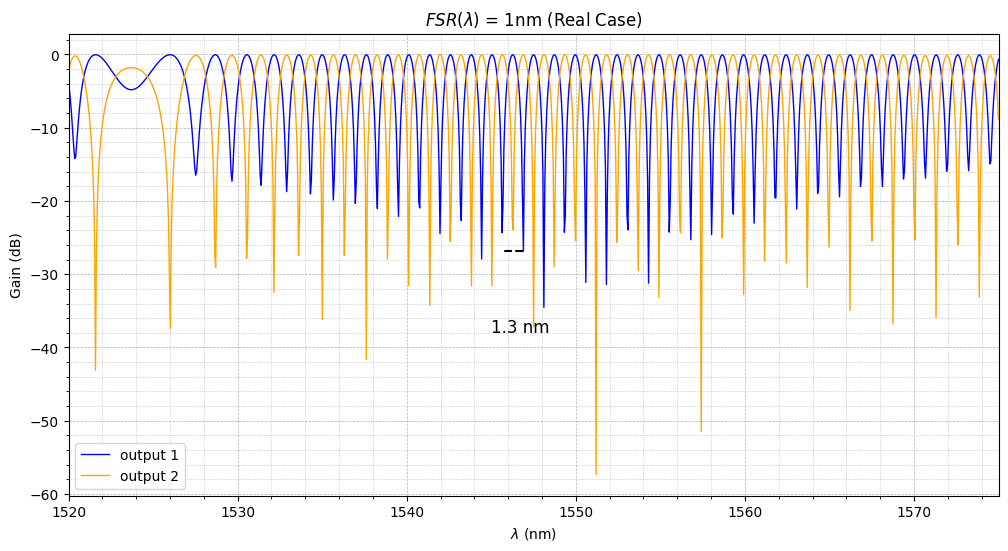

In [47]:
gain = interApi.getresult("ONA", "input 1/mode 1/gain")
wavelength_1 = gain['wavelength']
gain = gain['mode 1 gain (dB)']

gain_2 = interApi.getresult("ONA", "input 2/mode 1/gain")
wavelength_2 = gain_2['wavelength']
gain_2 = gain_2['mode 1 gain (dB)']

min_indices, _ = find_peaks(-np.array(gain))

if len(min_indices) >= 2:
    min_1, min_2 = min_indices[22:24]  
    x_min_1, x_min_2 = wavelength_1[min_1] / nm, wavelength_1[min_2] / nm
    y_min = gain[min_1]

    plt.figure(figsize=(12, 6))
    plt.plot(wavelength_1 / nm, gain, lw=1, label='output 1', color='blue')
    plt.plot(wavelength_2 / nm, gain_2, lw=1, label='output 2', color='orange')

    plt.hlines(y=y_min, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
    plt.text(1545, -38, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)

    plt.xlabel('$\lambda$ (nm)')
    plt.ylabel('Gain (dB)')
    plt.xlim([1520, 1575])
    
    plt.title('$FSR(\lambda)$ = 1nm (Real Case)')
    plt.minorticks_on()
    plt.grid(which='both', linestyle='--', linewidth=0.5)  
    plt.grid(which='minor', linestyle=':', linewidth=0.5) 

    plt.legend(loc='best')
    plt.savefig('FSR_1nm_REAL', bbox_inches='tight')
    plt.show()

In [48]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1 = np.array(FSR_1['wavelength']).flatten()
fsrplot_1 = np.array(FSR_1['mode 1 free spectral range (m)'])

wavelength_2 = np.array(FSR_2['wavelength']).flatten()
fsrplot_2 = np.array(FSR_2['mode 1 free spectral range (m)'])  

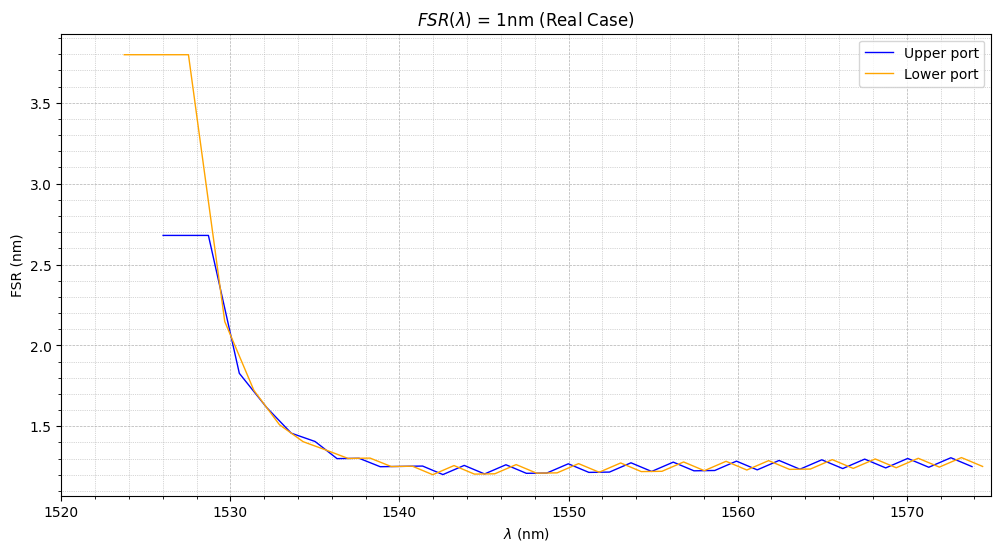

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, fsrplot_1/nm, lw=1, label='Upper port', color='blue')
plt.plot(wavelength_2 / nm, fsrplot_2/nm, lw=1, label='Lower port', color='orange')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([1520, 1575])
    
plt.title('$FSR(\lambda)$ = 1nm (Real Case)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_1nm_x_wvlength', bbox_inches='tight')
plt.show()

## $FSR(\lambda)=10nm$

In [50]:
interApi.switchtolayout()
interApi.select('wg_2')
interApi.delete()

interApi.addelement('MODE Waveguide')
interApi.set('name', 'wg_2')
interApi.set('ldf filename', r"C:\Users\alves\Documents\Photonics\Mach–Zehnder interferometer\Real simulation\wvg_mode.ldf")
interApi.set('length', L + delta_L[1])

In [51]:
#positions
interApi.setposition('wg_2', 0, 400)

In [52]:
# connection

interApi.connect("coupler_1", "port lower 2", "wg_2", "port 1")
interApi.connect("wg_2", "port 2", "coupler_2", "port lower 1")

1.0

In [53]:
interApi.run()

C:\Users\alves\AppData\Local\Temp\ipykernel_15396\2011994035.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(1543, -32, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)


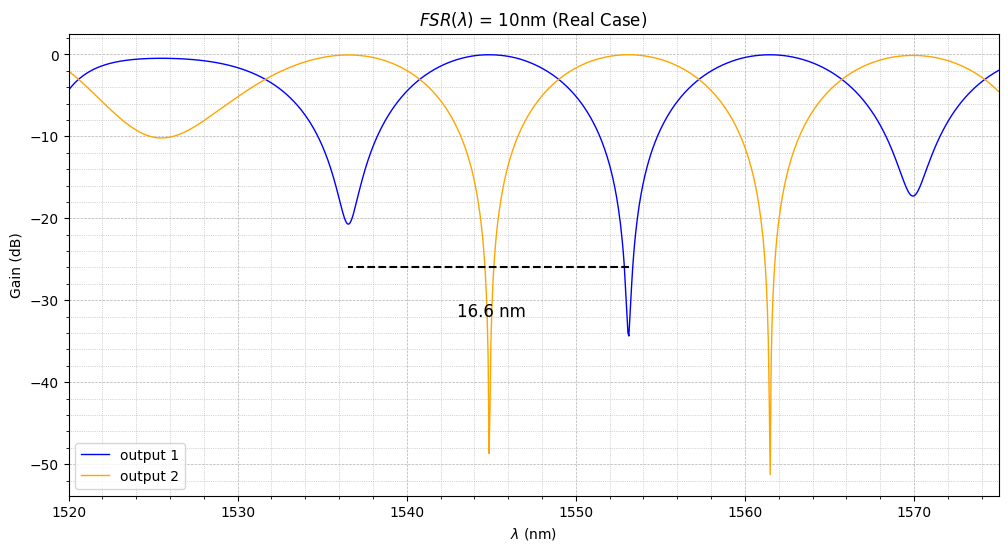

In [54]:
gain = interApi.getresult("ONA", "input 1/mode 1/gain")
wavelength_1 = gain['wavelength']
gain = gain['mode 1 gain (dB)']

gain_2 = interApi.getresult("ONA", "input 2/mode 1/gain")
wavelength_2 = gain_2['wavelength']
gain_2 = gain_2['mode 1 gain (dB)']

min_indices, _ = find_peaks(-np.array(gain))

if len(min_indices) >= 2:
    min_1, min_2 = min_indices[1:3]  
    x_min_1, x_min_2 = wavelength_1[min_1] / nm, wavelength_1[min_2] / nm
    y_min = gain[min_1]

    plt.figure(figsize=(12, 6))
    plt.plot(wavelength_1 / nm, gain, lw=1, label='output 1', color='blue')
    plt.plot(wavelength_2 / nm, gain_2, lw=1, label='output 2', color='orange')

    plt.hlines(y=-26, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
    plt.text(1543, -32, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)

    plt.xlabel('$\lambda$ (nm)')
    plt.ylabel('Gain (dB)')
    plt.xlim([1520, 1575])
    
    plt.title('$FSR(\lambda)$ = 10nm (Real Case)')
    plt.minorticks_on()
    plt.grid(which='both', linestyle='--', linewidth=0.5)  
    plt.grid(which='minor', linestyle=':', linewidth=0.5) 

    plt.legend(loc='best')
    plt.savefig('FSR_10nm_REAL', bbox_inches='tight')
    plt.show()

In [55]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1 = np.array(FSR_1['wavelength']).flatten()
fsrplot_1 = np.array(FSR_1['mode 1 free spectral range (m)'])

wavelength_2 = np.array(FSR_2['wavelength']).flatten()
fsrplot_2 = np.array(FSR_2['mode 1 free spectral range (m)'])  

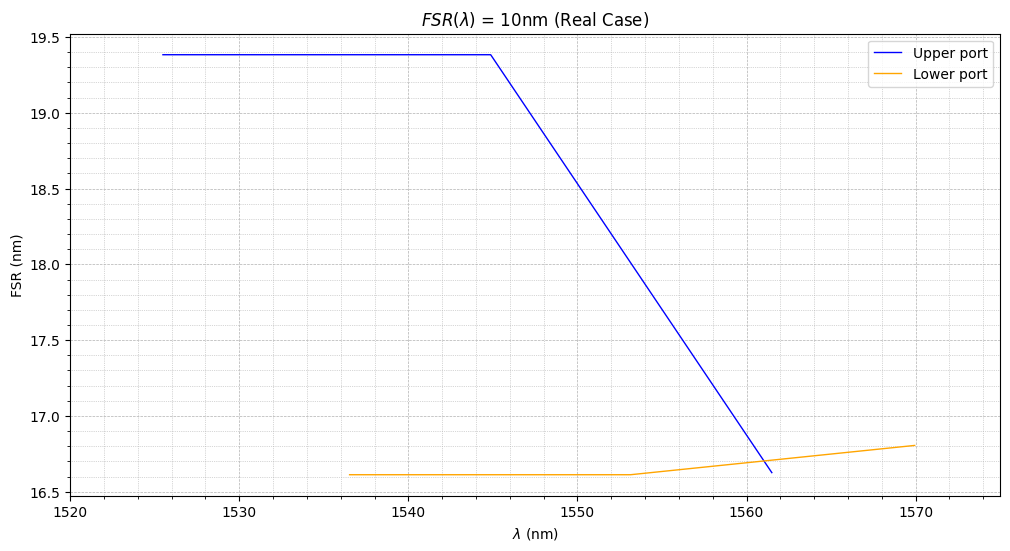

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, fsrplot_1/nm, lw=1, label='Upper port', color='blue')
plt.plot(wavelength_2 / nm, fsrplot_2/nm, lw=1, label='Lower port', color='orange')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([1520, 1575])
    
plt.title('$FSR(\lambda)$ = 10nm (Real Case)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_10nm_x_wvlength', bbox_inches='tight')
plt.show()

## $FSR(\lambda)=20nm$

In [57]:
interApi.switchtolayout()
interApi.select('wg_2')
interApi.delete()

interApi.addelement('MODE Waveguide')
interApi.set('name', 'wg_2')
interApi.set('ldf filename', r"C:\Users\alves\Documents\Photonics\Mach–Zehnder interferometer\Real simulation\wvg_mode.ldf")
interApi.set('length', L + delta_L[2])

In [58]:
#positions
interApi.setposition('wg_2', 0, 400)

In [59]:
# connection

interApi.connect("coupler_1", "port lower 2", "wg_2", "port 1")
interApi.connect("wg_2", "port 2", "coupler_2", "port lower 1")

1.0

In [60]:
interApi.run()

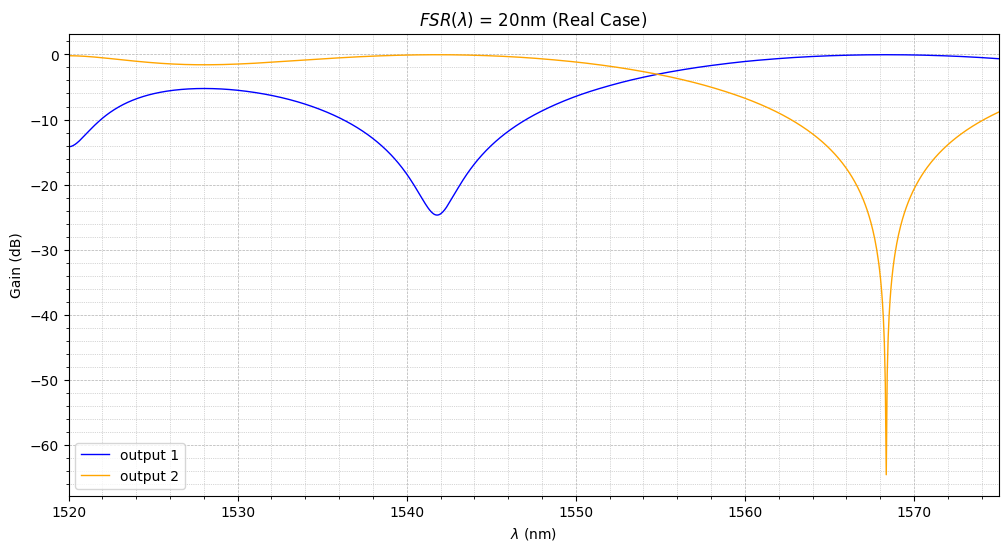

In [61]:
gain = interApi.getresult("ONA", "input 1/mode 1/gain")
wavelength_1 = gain['wavelength']
gain = gain['mode 1 gain (dB)']

gain_2 = interApi.getresult("ONA", "input 2/mode 1/gain")
wavelength_2 = gain_2['wavelength']
gain_2 = gain_2['mode 1 gain (dB)']

plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, gain, lw=1, label='output 1', color='blue')
plt.plot(wavelength_2 / nm, gain_2, lw=1, label='output 2', color='orange')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Gain (dB)')
plt.xlim([1520, 1575])
        
plt.title('$FSR(\lambda)$ = 20nm (Real Case)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_20nm_REAL', bbox_inches='tight')
plt.show()

In [62]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1 = np.array(FSR_1['wavelength']).flatten()
fsrplot_1 = np.array(FSR_1['mode 1 free spectral range (m)'])

wavelength_2 = np.array(FSR_2['wavelength']).flatten()
fsrplot_2 = np.array(FSR_2['mode 1 free spectral range (m)'])  

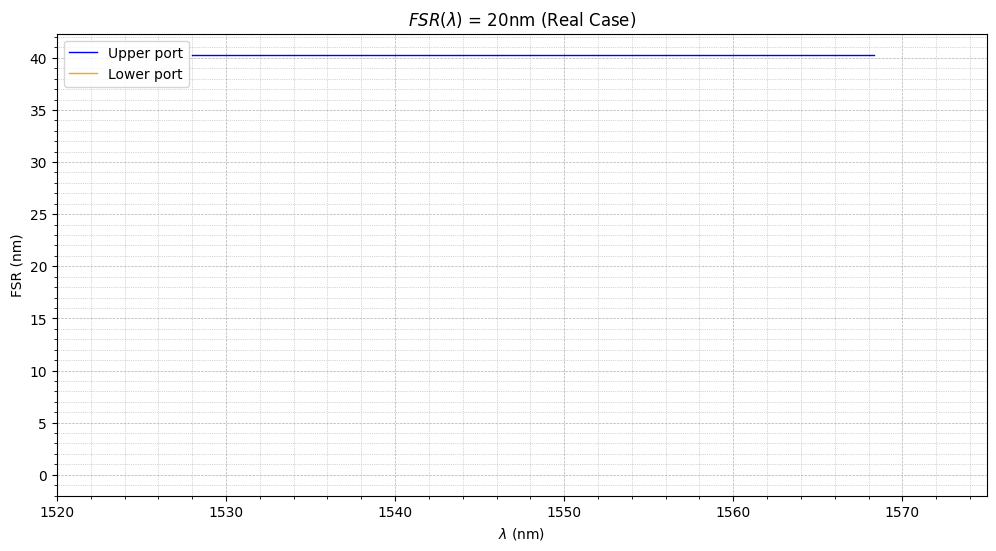

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, fsrplot_1/nm, lw=1, label='Upper port', color='blue')
plt.plot(wavelength_2 / nm, fsrplot_2/nm, lw=1, label='Lower port', color='orange')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([1520, 1575])
    
plt.title('$FSR(\lambda)$ = 20nm (Real Case)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_20nm_x_wvlength', bbox_inches='tight')
plt.show()